In [1]:
from omegaconf import OmegaConf

config = OmegaConf.load("clip.yaml")
config
from lightning_data import IRRADataModule

dm = IRRADataModule(config)
dm.setup()
train = dm.train_set

/home/phongtnh/miniconda3/envs/person_search/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


VN3K


In [2]:
train[4]

{'pids': tensor([0]),
 'image_ids': tensor([1]),
 'images': tensor([[[-1.7923, -1.7923, -1.7923,  ..., -0.3178, -0.3762, -0.4054],
          [-1.7923, -1.7923, -1.7923,  ..., -0.2448, -0.2886, -0.2156],
          [-1.7923, -1.7923, -1.7923,  ...,  0.3391,  0.3099,  0.3391],
          ...,
          [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
          [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
          [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923]],
 
         [[-1.7521, -1.7521, -1.7521,  ..., -0.2213, -0.2963, -0.3264],
          [-1.7521, -1.7521, -1.7521,  ..., -0.1463, -0.1913, -0.1313],
          [-1.7521, -1.7521, -1.7521,  ...,  0.4240,  0.3940,  0.4390],
          ...,
          [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
          [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
          [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521]],
 
         [[-1.4802, -1.4802, -1.4802,  ..

In [3]:
from lightning.pytorch import seed_everything

seed_everything(42)

Seed set to 42


42

In [4]:
train_loader = dm.train_dataloader()
test_loader = dm.test_dataloader()

In [5]:
next(iter(train_loader))

{'image_ids': tensor([[3803],
         [3803],
         [3803],
         [3803]]),
 'images': tensor([[[[-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
           [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
           [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
           ...,
           [-0.0113, -0.0113,  0.0033,  ..., -1.7923, -1.7923, -1.7923],
           [-0.0696, -0.0842, -0.0988,  ..., -1.7923, -1.7923, -1.7923],
           [-0.1134, -0.1426, -0.1572,  ..., -1.7923, -1.7923, -1.7923]],
 
          [[-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
           [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
           [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
           ...,
           [-0.0262, -0.0262, -0.0112,  ..., -1.7521, -1.7521, -1.7521],
           [-0.0862, -0.1012, -0.1163,  ..., -1.7521, -1.7521, -1.7521],
           [-0.1313, -0.1613, -0.1763,  ..., -1.7521, -1.7521, -1.752

In [7]:
from omegaconf import OmegaConf
from utils.tokenizer_utils import get_tokenizer

config = OmegaConf.load("clip.yaml")
config

tokenizer = get_tokenizer(config.tokenizer)

-100

In [12]:
tokenizer.pad

SiglipTokenizer(name_or_path='/home/phongtnh/Person-Search/person_rlf/siglip_checkpoints', vocab_size=250100, model_max_length=64, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '</s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	1: AddedToken("</s>", rstrip=True, lstrip=True, single_word=False, normalized=False, special=True),
	2: AddedToken("<unk>", rstrip=True, lstrip=True, single_word=False, normalized=False, special=True),
	250000: AddedToken("<mask>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [2]:
tokenizer.pad_token_id

NameError: name 'tokenizer' is not defined

In [15]:
special_tokens_mask = [
    [1 if val in tokenizer.special_token_ids else 0 for val in label]
    for label in labels.tolist()
]
special_tokens_mask

[[0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]]

In [16]:
probability_matrix.masked_fill_(
    torch.tensor(special_tokens_mask, dtype=torch.bool), value=0.0
)

tensor([[0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500,
         0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500,
         0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500,
         0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500, 0.1500,
         0.1500, 0.1500, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]])

In [18]:
masked_indices = torch.bernoulli(probability_matrix).bool()
masked_indices

tensor([[False,  True, False,  True,  True, False, False, False,  True,  True,
         False,  True, False, False, False, False, False, False, False,  True,
          True, False, False, False, False, False, False, False, False, False,
          True, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False]])

In [19]:
labels[~masked_indices] = -100  # We only compute loss on masked tokens

In [20]:
labels

tensor([[ -100, 25972,  -100,   259,   262,  -100,  -100,  -100,   347,   259,
          -100, 33264,  -100,  -100,  -100,  -100,  -100,  -100,  -100,   287,
         79995,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
         33264,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100]])

In [28]:
masked_indices = torch.bernoulli(probability_matrix).bool()
labels[~masked_indices] = -100  # We only compute loss on masked tokens

In [29]:
labels

tensor([[ -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,   259,  -100,  -100,  -100,  -100, 94221,  -100,   287,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
          -100,  -100,  -100,  -100]])

In [30]:
indices_replaced = (
    torch.bernoulli(torch.full(labels.shape, 0.8)).bool() & masked_indices
)
inputs[indices_replaced] = mask_token

NameError: name 'mask_token' is not defined

In [ ]:
key_to_check = ["caption_input", "mlm_inputs", "mlm_labels"]

In [ ]:
print("Image shape:", train[0]["images"].shape)
print("Caption shape:", train[0]["caption_input"]["input_ids"].shape)

Image shape: torch.Size([3, 384, 128])
Caption shape: torch.Size([1, 64])


In [ ]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()

In [ ]:
train_loader.batch_size

8

In [ ]:
config.max_epochs

1

In [ ]:
# Calculate total training steps
num_training_steps = len(train_loader) * config.max_epochs
num_warmup_steps = int(num_training_steps * config.warmup_ratio)

In [ ]:
num_training_steps

2151

In [ ]:
num_warmup_steps

21

In [ ]:
import lightning as L
from lighning_models import LitIRRA

model = LitIRRA(
    config,
    img_loader=test_loader[0],
    text_loader=test_loader[1],
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps,
    num_classes=dm.num_classes,
)

In [ ]:
model.model(next(iter(train_loader)))

{'temperature': tensor(0.0200),
 'sdm_loss': tensor(0., grad_fn=<AddBackward0>),
 'id_loss': tensor(7.5937, grad_fn=<MulBackward0>),
 'img_acc': tensor(0.),
 'txt_acc': tensor(0.),
 'mlm_loss': tensor(12.3301, grad_fn=<MulBackward0>),
 'mlm_acc': tensor(0.)}

In [ ]:
test_img = next(iter(train_loader))["images"]
test_caption = next(iter(train_loader))["caption_input"]

In [ ]:
model.model.encode_image(test_img).shape

torch.Size([8, 768])

In [ ]:
model.model.encode_text(test_caption).shape

torch.Size([8, 768])

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(monitor="eval_score")

In [ ]:
from lightning.pytorch.loggers import TensorBoardLogger

logger = TensorBoardLogger("tb_logs", name="my_model")
trainer = L.Trainer(
    precision="bf16-mixed",
    logger=logger,
    max_epochs=config.num_epochs,
    accumulate_grad_batches=16,
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.predict(model, test_loader)

MisconfigurationException: `Trainer.predict` requires `forward` method to run.

In [ ]:
trainer.fit(model, train_dataloaders=train_loader)

In [ ]:
def collate(batch):
    # Initialize dictionary to hold batched data
    batched_data = {}

    # Get all keys from the first item in the batch to identify field names
    keys = batch[0].keys()

    for key in keys:
        if isinstance(batch[0][key], dict):
            # If the field is a nested dictionary, process each sub-field
            sub_keys = batch[0][key].keys()
            batched_data[key] = {}
            for sub_key in sub_keys:
                sub_values = [item[key][sub_key] for item in batch]
                if isinstance(sub_values[0], torch.Tensor):
                    # Concatenate tensors
                    batched_data[key][sub_key] = torch.cat(sub_values, dim=0)
                else:
                    # Assume list of primitive types and convert to tensor
                    batched_data[key][sub_key] = torch.tensor(
                        sub_values, dtype=torch.int64
                    )
        else:
            # If the field is not a nested dictionary, process directly
            values = [item[key] for item in batch]
            if isinstance(values[0], torch.Tensor):
                # Stack tensors if they are of the same size
                batched_data[key] = torch.stack(values)
            else:
                # Assume list of primitive types and convert to tensor
                batched_data[key] = torch.tensor(values, dtype=torch.int64)

    return batched_data


train = dm.train_set

In [ ]:
train[2]

{'pids': 0,
 'image_ids': 0,
 'images': tensor([[[ 0.0617,  0.0763,  0.0471,  ..., -1.7923, -1.7923, -1.7923],
          [ 0.1055,  0.1055,  0.0617,  ..., -1.7923, -1.7923, -1.7923],
          [ 0.0325,  0.0471,  0.0325,  ..., -1.7923, -1.7923, -1.7923],
          ...,
          [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
          [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923],
          [-1.7923, -1.7923, -1.7923,  ..., -1.7923, -1.7923, -1.7923]],
 
         [[-0.6415, -0.6565, -0.6865,  ..., -1.7521, -1.7521, -1.7521],
          [-0.5965, -0.6265, -0.6715,  ..., -1.7521, -1.7521, -1.7521],
          [-0.6565, -0.6715, -0.7016,  ..., -1.7521, -1.7521, -1.7521],
          ...,
          [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
          [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521],
          [-1.7521, -1.7521, -1.7521,  ..., -1.7521, -1.7521, -1.7521]],
 
         [[-0.3853, -0.3711, -0.3995,  ..., -1.4802, -1.4802,

In [4]:
siglip_config = {
    "architectures": ["SiglipModel"],
    "initializer_factor": 1.0,
    "model_type": "siglip",
    "text_config": {
        "model_type": "siglip_text_model",
        "vocab_size": 250001,
        "max_position_embeddings": 77,
    },
    "torch_dtype": "float32",
    "transformers_version": "4.37.0.dev0",
    "vision_config": {"image_size": [384, 128], "model_type": "siglip_vision_model"},
}

In [5]:
from model.siglip.modeling_siglip import SiglipModel
from model.siglip.configuration_siglip import SiglipConfig

config = SiglipConfig(**siglip_config)
model = SiglipModel(**config)

TypeError: model.siglip.modeling_siglip.SiglipModel() argument after ** must be a mapping, not SiglipConfig

In [10]:
for name, param in model.named_parameters():
    # Check the name of position embeddings of the text model
    if "text" in name and "position" in name and "embed" in name:
        text_model_position_embedding = name
        text_model_position_embedding_shape = param.shape[0]
    # Check the name of token embeddings of the text model
    if "text" in name and "token" in name and "embed" in name:
        text_model_token_embedding = name
        text_model_token_embedding_shape = param.shape[0]
    # Check the name of position embeddings of the image model
    if "position" in name and "embed" in name:
        if "vision" in name or "visual" in name or "image" in name:
            image_model_position_embedding = name
            image_model_position_embedding_shape = param.shape[0]

In [11]:
text_model_position_embedding, text_model_position_embedding_shape

('text_model.embeddings.position_embedding.weight', 77)

In [12]:
text_model_token_embedding, text_model_token_embedding_shape

('text_model.embeddings.token_embedding.weight', 250001)

In [13]:
image_model_position_embedding, image_model_position_embedding_shape

('vision_model.embeddings.position_embedding.weight', 192)

In [20]:
from safetensors.torch import load_file

state_dict = load_file(
    "/home/phongtnh/Person-Search/person_rlf/siglip_checkpoints/model.safetensors"
)

In [22]:
state_dict[text_model_position_embedding].shape

torch.Size([64, 768])

In [15]:
state_dict.keys()

dict_keys(['logit_bias', 'logit_scale', 'text_model.embeddings.position_embedding.weight', 'text_model.embeddings.token_embedding.weight', 'text_model.encoder.layers.0.layer_norm1.bias', 'text_model.encoder.layers.0.layer_norm1.weight', 'text_model.encoder.layers.0.layer_norm2.bias', 'text_model.encoder.layers.0.layer_norm2.weight', 'text_model.encoder.layers.0.mlp.fc1.bias', 'text_model.encoder.layers.0.mlp.fc1.weight', 'text_model.encoder.layers.0.mlp.fc2.bias', 'text_model.encoder.layers.0.mlp.fc2.weight', 'text_model.encoder.layers.0.self_attn.k_proj.bias', 'text_model.encoder.layers.0.self_attn.k_proj.weight', 'text_model.encoder.layers.0.self_attn.out_proj.bias', 'text_model.encoder.layers.0.self_attn.out_proj.weight', 'text_model.encoder.layers.0.self_attn.q_proj.bias', 'text_model.encoder.layers.0.self_attn.q_proj.weight', 'text_model.encoder.layers.0.self_attn.v_proj.bias', 'text_model.encoder.layers.0.self_attn.v_proj.weight', 'text_model.encoder.layers.1.layer_norm1.bias', '

In [16]:
from utils.layer_resize import resize_text_pos_embedding, resize_token_embedding

In [23]:
if (
    state_dict[text_model_position_embedding].shape[0]
    != text_model_position_embedding_shape
):
    print(
        f"Resizing text model position embedding from {state_dict[text_model_position_embedding].shape[0]} to {text_model_position_embedding_shape}"
    )
    state_dict[text_model_position_embedding] = resize_text_pos_embedding(
        state_dict[text_model_position_embedding],
        target_dim=text_model_position_embedding_shape,
    )
    print(state_dict[text_model_position_embedding].shape)

Resizing text model position embedding from 64 to 77
torch.Size([77, 768])


In [19]:
state_dict[text_model_position_embedding].shape

torch.Size([77, 768])

In [12]:
import torch


@torch.no_grad()
def modify_params_weight(model):
    for name, param in text_model.named_parameters():
        if "position" in name and "embedding" in name:
            print(name)
            position_embedding = resize_text_pos_embedding(param, ignore="first")
            print(position_embedding)
            param.data = position_embedding
            # Update model info
            model.config.text_config.position_embedding_size = position_embedding.size(
                1
            )
        # elif 'token' in name and 'embedding' in name:
        #     token_embedding = resize_token_embedding(param, ignore="first")
        #     param = token_embedding

In [25]:
tex

SiglipTextConfig {
  "_name_or_path": "siglip_checkpoints",
  "attention_dropout": 0.0,
  "bos_token_id": 49406,
  "eos_token_id": 49407,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_size": 768,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-06,
  "max_position_embeddings": 64,
  "model_type": "siglip_text_model",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "transformers_version": "4.40.2",
  "vocab_size": 250000
}

In [24]:
text_model.text_model.embeddings.position_embedding.weight.shape

torch.Size([77, 768])

In [12]:
modify_params_weight(text_model)

text_model.embeddings.position_embedding.weight
Parameter containing:
tensor([[-6.4781e-02, -1.3846e-02,  2.2669e-04,  ..., -3.6059e-02,
          6.7947e-02,  3.2825e-02],
        [-5.6405e-02,  2.2390e-02, -3.7283e-02,  ...,  7.4557e-02,
         -3.4371e-03,  6.5015e-02],
        [-6.8742e-02,  6.4525e-03,  6.7116e-03,  ...,  2.3484e-02,
          2.4183e-02,  5.6726e-02],
        ...,
        [ 9.5946e-02, -1.4957e-01,  7.9668e-02,  ...,  1.0009e-01,
         -2.4498e-02, -1.5330e-02],
        [ 1.0203e-02, -3.4751e-02,  1.3561e-01,  ...,  2.2974e-01,
         -3.6014e-03,  9.4231e-02],
        [-1.2788e-01, -5.5406e-02,  8.7895e-02,  ...,  6.7243e-02,
          1.1804e-01,  1.5169e-01]], requires_grad=True)


In [8]:
text_model

SiglipTextModel(
  (text_model): SiglipTextTransformer(
    (embeddings): SiglipTextEmbeddings(
      (token_embedding): Embedding(250000, 768)
      (position_embedding): Embedding(64, 768)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-11): 12 x SiglipEncoderLayer(
          (self_attn): SiglipAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): PytorchGELUTanh()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((76

In [ ]:
position_embedding = resize_text_pos_embedding(position_embedding, ignore="first")

In [ ]:
for name, param in text_model.named_parameters():
    if "position" in name and "embedding" in name:
        position_embedding = resize_text_pos_embedding(param, ignore="first")
        param = position_embedding

In [ ]:
text_model

SiglipTextModel(
  (text_model): SiglipTextTransformer(
    (embeddings): SiglipTextEmbeddings(
      (token_embedding): Embedding(250000, 768)
      (position_embedding): Embedding(64, 768)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-11): 12 x SiglipEncoderLayer(
          (self_attn): SiglipAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): PytorchGELUTanh()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((76

In [ ]:
def replace_model_weight(name, weight):
    for name, param in text_model.named_parameters():
        if name == name:
            param.data = weight

In [ ]:
position_embedding

Parameter containing:
tensor([[-6.4781e-02, -1.3846e-02,  2.2669e-04,  ..., -3.6059e-02,
          6.7947e-02,  3.2825e-02],
        [-5.6405e-02,  2.2390e-02, -3.7283e-02,  ...,  7.4557e-02,
         -3.4371e-03,  6.5015e-02],
        [-7.3000e-02,  9.5201e-04,  2.1896e-02,  ...,  5.8575e-03,
          3.3716e-02,  5.3865e-02],
        ...,
        [ 1.2440e-01, -2.4068e-01,  2.5565e-02,  ..., -3.8673e-02,
         -8.7440e-03, -8.2370e-02],
        [ 5.7860e-02, -2.7623e-02,  1.5208e-01,  ...,  2.8583e-01,
         -4.5584e-02,  7.4401e-02],
        [-1.2788e-01, -5.5406e-02,  8.7895e-02,  ...,  6.7243e-02,
          1.1804e-01,  1.5169e-01]], requires_grad=True)

In [ ]:
text_model

SiglipTextModel(
  (text_model): SiglipTextTransformer(
    (embeddings): SiglipTextEmbeddings(
      (token_embedding): Embedding(250000, 768)
      (position_embedding): Embedding(64, 768)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-11): 12 x SiglipEncoderLayer(
          (self_attn): SiglipAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): PytorchGELUTanh()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((76

In [ ]:
tokenizer.vocab_size = 250001

AttributeError: property 'vocab_size' of 'SiglipTokenizer' object has no setter

In [ ]:
mask_token = tokenizer.convert_ids_to_tokens(250000)
tokenizer.add_special_tokens({"mask_token": mask_token})

0

In [ ]:
!kill $(lsof -t -i:6006)

In [ ]:
_, scheduler = model.configure_optimizers()

Using 5.0 times learning rate for random init module 


In [ ]:
scheduler[0]

/home/phongtnh/miniconda3/envs/person_search/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


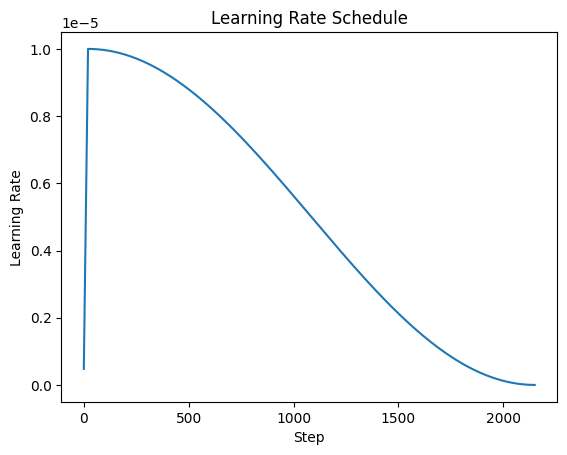

In [ ]:
import matplotlib.pyplot as plt

lrs = []
for step in range(num_training_steps):
    scheduler[0].step()
    lrs.append(scheduler[0].get_last_lr()[0])

plt.plot(lrs)
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.show()

In [ ]:
from utils.parse_module_str import parse_module_str

tokenizer = parse_module_str("model.clip.simple_tokenizer.SimpleTokenizer")

In [1]:
from utils.parse_module_str import parse_module_str

config = parse_module_str("dict", a=1, b=2, c=3)

In [2]:
config

{'a': 1, 'b': 2, 'c': 3}

In [ ]:
from model.clip.clip import load, available_models

available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [ ]:
model, _ = load("ViT-B/16", download_root="./clip_checkpoints")

In [ ]:
model

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [ ]:
from PIL import Image

img = Image.open(
    "/home/phongtnh/Person-Search/person_rlf/VN3K/imgs/DANgoc_01/02885_2.jpg"
)

In [12]:
from utils.tokenizer_utils import get_tokenizer

tokenizer = get_tokenizer(
    {"type": "model.clip.simple_tokenizer.SimpleTokenizer", "vocab_size": 49409}
)

In [2]:
tokenizer.special_token_ids

NameError: name 'tokenizer' is not defined

In [6]:
for token in tokenizer.cache.values():
    print(tokenizer.encoder[token])

49406
49407
49408


In [13]:
from omegaconf import OmegaConf
from utils.tokenizer_utils import get_tokenizer

config = OmegaConf.load("siglip.yaml")
config

tokenizer = get_tokenizer(config.tokenizer)

In [15]:
tokenizer(
    text,
    context_length=64,
    padding="max_length",
    truncation=True,
    return_tensors="pt",
    return_attention_mask=True,
)

Keyword arguments {'context_length': 64} not recognized.


{'input_ids': tensor([[  259,   272,  2342, 31029,   297,   259,   272,  9816,   259,   471,
           268,  1452,   273,   355,   278,   885,   331,  3633,   562,  2342,
           534,  7281,  7020,   594,  1849,   819,  1313, 11095, 28132,  1452,
           273,   355,   278,  3767,   718, 48066,   394,   924, 71949,   534,
          7281,   259,   270,  1075,  4195,   317,  1544,  1452,   273,   534,
          7281,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])}

In [4]:
# get special toke map id
tokenizer.special_token_ids

[1, 2, 1, 250000]

In [ ]:
from datasets.cuhkpedes import CUHKPEDES

dataset = CUHKPEDES()

In [ ]:
tokenizer(
    "This is a very long long long long long long long long long long long long long long long long long long long long long long long long setence"
)

{'input_ids': tensor([[49406,   589,   533,   320,  1070,  1538,  1538,  1538,  1538,  1538,
           1538,  1538,  1538,  1538,  1538,  1538,  1538,  1538,  1538,  1538,
           1538,  1538,  1538,  1538,  1538,  1538,  1538,  1538,  1538,  7965,
            954, 49407,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
           -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
           -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
           -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,  -100,
           -100,  -100,  -100,  -100,  -100,  -100,  -100]])}

In [13]:
tokenizer.mask_token_id

250000

In [ ]:
test = "This is a very long long long long long long long long long long long long long long long long long long long long long long long long setence"

In [ ]:
tokenizer.decode(test["input_ids"])

'this is a very long long long long long long long long long long long long long long long long long long long long long long long long setence</s>'

In [ ]:
def tokenize(caption: str, tokenizer, context_length, truncate=True):
    inputs = tokenizer(
        caption,
        context_length=context_length,
        padding="max_length",
        truncation=truncate,
        return_tensors="pt",
        return_attention_mask=True,
    )
    return inputs

In [ ]:
tokenize(test, tokenizer, 77, truncate=True)["input_ids"].squeeze()[0]

tensor(49406)

In [ ]:
tokenizer.decode(tokenize(test, tokenizer, 77, truncate=True)["input_ids"])

'<|startoftext|>this is a very long long long long long long long long long long long long long long long long long long long long long long long long setence <|endoftext|>'

In [1]:
from omegaconf import OmegaConf

config = OmegaConf.load("clip.yaml")
config
from lightning_data import IRRADataModule

dm = IRRADataModule(config)
dm.setup()
train = dm.train_set

/home/phongtnh/miniconda3/envs/person_search/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


VN3K


In [2]:
train_loader = dm.train_dataloader()

In [4]:
test = next(iter(train_loader))

In [9]:
test['images'].shape

torch.Size([32, 3, 384, 128])

In [10]:
test['caption_input_ids'].shape

torch.Size([32, 77])

In [12]:
test['mlm_input_ids'].shape

torch.Size([32, 77])

In [ ]:
from model.build import build_backbone_with_proper_layer_resize

model = build_backbone_with_proper_layer_resize(config.backbone)

In [15]:
model.to("cuda")

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [16]:
img = test['images']

In [17]:
img.shape

torch.Size([32, 3, 384, 128])

In [19]:
import torch
with torch.no_grad():
    output = model.get_image_features(
        pixel_values=img.to("cuda"),
        output_last_hidden_state=True,
        return_dict=True
    )

In [20]:
output['pooler_output'].shape

torch.Size([32, 512])

In [22]:
output['last_hidden_state'].shape

torch.Size([32, 193, 512])

In [21]:
test["caption_input_ids"].shape

torch.Size([32, 77])

In [24]:
with torch.no_grad():
    output = model.get_text_features(
        input_ids=test["caption_input_ids"].to("cuda"),
        # attention_mask=train[0]["caption_attention_mask"].unsqueeze(0).to("cuda"),
        return_dict=True
    )

../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [52,0,0], thread: [0,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [52,0,0], thread: [1,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [52,0,0], thread: [2,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [52,0,0], thread: [3,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [52,0,0], thread: [4,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [52,0,0], thread: [5,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [52,0,0], thread:

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [34]:
output['pooler_output'].shape

torch.Size([2, 512])

In [35]:
output['last_hidden_state'].shape

torch.Size([2, 77, 512])

In [ ]:
@torch.no_grad()
def resize_pos_embed(posemb, height, width):
    # Rescale the grid of position embeddings when loading from state_dict. Adapted from
    # https://github.com/google-research/vision_transformer/blob/00883dd691c63a6830751563748663526e811cee/vit_jax/checkpoint.py#L224
    posemb = posemb.unsqueeze(0)

    posemb_token, posemb_grid = posemb[:, :1], posemb[0, 1:]

    gs_old = int(math.sqrt(len(posemb_grid)))
    posemb_grid = posemb_grid.reshape(1, gs_old, gs_old, -1).permute(0, 3, 1, 2)
    posemb_grid = F.interpolate(posemb_grid, size=(height, width), mode="bilinear")
    posemb_grid = posemb_grid.permute(0, 2, 3, 1).reshape(1, height * width, -1)
    posemb = torch.cat([posemb_token, posemb_grid], dim=1)
    return posemb.squeeze(0)

In [4]:
from safetensors.torch import load_file

state_dict = load_file(
    "/home/phongtnh/Person-Search/person_rlf/siglip_checkpoints/model.safetensors"
)


In [5]:
posemb = state_dict['vision_model.embeddings.position_embedding.weight']

In [6]:
posemb.shape

torch.Size([256, 768])

In [8]:
import math
import torch.nn.functional as F
include_cls_token = True
posemb = posemb.unsqueeze(0)
posemb_token = None

if include_cls_token:
    posemb_grid = posemb[0, :]
else:
    posemb_token, posemb_grid = posemb[:, :1], posemb[0, 1:]

# Reshape into a 2D grid to keep the structure of an image
gs_old = int(math.sqrt(len(posemb_grid)))
posemb_grid = posemb_grid.reshape(1, gs_old, gs_old, -1).permute(0, 3, 1, 2)

# Interpolate grid of position embeddings
posemb_grid = F.interpolate(posemb_grid, size=(24, 8), mode="bilinear")
posemb_grid = posemb_grid.permute(0, 2, 3, 1).reshape(1, 24 * 8, -1)

# Concatenate the first token if it was ignored if the originam posemb had a CLS token
if posemb_token:
    print(torch.cat([posemb_token, posemb_grid.squeeze(0)], dim=0))
else:
    print(posemb_grid.squeeze(0))

tensor([[ 0.0606,  0.0668,  0.0189,  ..., -0.0221, -0.0020, -0.0254],
        [ 0.0606,  0.0668,  0.0189,  ..., -0.0221, -0.0020, -0.0254],
        [ 0.0606,  0.0668,  0.0189,  ..., -0.0221, -0.0020, -0.0254],
        ...,
        [ 0.0606,  0.0668,  0.0189,  ..., -0.0221, -0.0020, -0.0254],
        [ 0.0606,  0.0668,  0.0189,  ..., -0.0221, -0.0020, -0.0254],
        [ 0.0606,  0.0668,  0.0189,  ..., -0.0221, -0.0020, -0.0254]])


In [52]:
posemb_token, posemb_grid = posemb[:, :1], posemb[0, :]

In [54]:
posemb_grid.shape

torch.Size([256, 768])

In [51]:
posemb_token.shape

torch.Size([1, 1, 768])

In [42]:
posemb_grid = posemb

In [43]:
posemb_grid.shape

torch.Size([1, 256, 768])

In [55]:
import math
gs_old = int(math.sqrt(len(posemb_grid)))
gs_old

16

In [56]:
posemb_grid.shape

torch.Size([256, 768])

In [57]:
posemb_grid.reshape(1, gs_old, gs_old, -1)

tensor([[[[ 6.0598e-02,  6.6767e-02,  1.8868e-02,  ...,  1.7853e-02,
            4.2891e-02, -3.2202e-02],
          [ 6.1810e-02,  1.3046e-01,  2.9045e-02,  ..., -2.1822e-02,
            4.8408e-02, -3.0584e-02],
          [ 5.2671e-02,  9.3742e-02,  1.7111e-02,  ..., -1.7024e-03,
            1.5958e-02, -2.9414e-02],
          ...,
          [ 6.3926e-02,  9.3750e-02,  1.9014e-02,  ..., -1.0340e-02,
            3.9934e-02, -3.7885e-02],
          [ 6.9173e-02,  4.7911e-02,  2.9768e-02,  ...,  1.4170e-02,
           -1.2070e-02, -2.6054e-02],
          [ 6.9872e-02,  2.2283e-02,  2.4796e-02,  ...,  7.7103e-03,
            7.8076e-03, -2.4767e-02]],

         [[ 5.5481e-02,  3.3013e-02,  1.0880e-02,  ...,  2.3799e-02,
            2.7303e-02, -3.0774e-02],
          [ 5.0566e-02,  5.8090e-02,  1.7412e-02,  ...,  1.5086e-02,
            5.7756e-03, -3.0999e-02],
          [ 5.4609e-02,  5.2114e-02,  1.7207e-02,  ...,  3.2391e-03,
            1.8216e-02, -3.1216e-02],
          ...,
     

In [58]:
posemb_grid = posemb_grid.reshape(1, gs_old, gs_old, -1).permute(0, 3, 1, 2)

In [19]:
model.to("cuda")

SiglipModel(
  (text_model): SiglipTextTransformer(
    (embeddings): SiglipTextEmbeddings(
      (token_embedding): Embedding(250001, 768)
      (position_embedding): Embedding(64, 768)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-11): 12 x SiglipEncoderLayer(
          (self_attn): SiglipAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): PytorchGELUTanh()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (layer_norm2): LayerNorm((768,),

In [14]:
text = "nữ tóc nâu , áo màu đen có dòng chữ trắng trước ngực , quần_đùi màu đen , đi giày thể_thao trắng , tất cao cổ màu trắng ."

In [27]:
config.tokenizer

{'pretrained_model_name_or_path': '/home/phongtnh/Person-Search/person_rlf/siglip_checkpoints'}

In [25]:
tokenizer = get_tokenizer(config.tokenizer)

NameError: name 'get_tokenizer' is not defined

In [5]:
import torch

state = (
    torch.jit.load(
        "/home/phongtnh/Person-Search/person_rlf/clip_checkpoints/ViT-B-16.pt",
        map_location="cpu",
    )
    .eval()
    .state_dict()
)

In [21]:
resize_token_embedding(state["token_embedding.weight"], 49409).shape

torch.Size([49416, 512])

In [ ]:
# check if the model distribtuion is

In [11]:
from torch import nn

new_embedding = nn.Embedding(49409, 768)

In [13]:
new_embedding.weight = nn.Parameter(state["token_embedding.weight"])

In [15]:
new_weights = F.interpolate(
    state["token_embedding.weight"],
    size=(49409, 768),
    mode="bilinear",
    align_corners=False,
)

torch.Size([49408, 512])

In [21]:
from safetensors.torch import load_file

state_dict = load_file(
    "/home/phongtnh/Person-Search/person_rlf/siglip_checkpoints/model.safetensors"
)

In [22]:
state_dict.keys()

dict_keys(['logit_bias', 'logit_scale', 'text_model.embeddings.position_embedding.weight', 'text_model.embeddings.token_embedding.weight', 'text_model.encoder.layers.0.layer_norm1.bias', 'text_model.encoder.layers.0.layer_norm1.weight', 'text_model.encoder.layers.0.layer_norm2.bias', 'text_model.encoder.layers.0.layer_norm2.weight', 'text_model.encoder.layers.0.mlp.fc1.bias', 'text_model.encoder.layers.0.mlp.fc1.weight', 'text_model.encoder.layers.0.mlp.fc2.bias', 'text_model.encoder.layers.0.mlp.fc2.weight', 'text_model.encoder.layers.0.self_attn.k_proj.bias', 'text_model.encoder.layers.0.self_attn.k_proj.weight', 'text_model.encoder.layers.0.self_attn.out_proj.bias', 'text_model.encoder.layers.0.self_attn.out_proj.weight', 'text_model.encoder.layers.0.self_attn.q_proj.bias', 'text_model.encoder.layers.0.self_attn.q_proj.weight', 'text_model.encoder.layers.0.self_attn.v_proj.bias', 'text_model.encoder.layers.0.self_attn.v_proj.weight', 'text_model.encoder.layers.1.layer_norm1.bias', '

In [1]:
import nltk